# Flowers Image Classification with TensorFlow

This notebook demonstrates how to do image classification from scratch on a flowers dataset.

## Learning Objectives
1. Know how to apply image augmentation
2. Know how to download and use a TensorFlow Hub module as a layer in Keras.

In [ ]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [1]:
import os
PROJECT = "ml-practice-260405" # REPLACE WITH YOUR PROJECT ID
BUCKET = "bucket-ml-practice-260405" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "2.1"  # Tensorflow version

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
import pathlib
from PIL import Image

import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)
import tensorflow_hub as hub

## Exploring the data

As usual, let's take a look at the data before we start building our model. We'll be using a creative-commons licensed flower photo dataset of 3670 images falling into 5 categories: 'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'.

The below [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) command downloads a dataset to the local Keras cache. To see the files through a terminal, copy the output of the cell below.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

# Print data path
print("cd", data_dir)

228818944/228813984 [==============================] - 119s 1us/step
cd /home/mujahid7292/.keras/datasets/flower_photos


We can use python's built in [pathlib](https://docs.python.org/3/library/pathlib.html) tool to get a sense of this unstructured data.

In [5]:
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")

CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print("These are the available classes:", CLASS_NAMES)

There are 3670 images.
These are the available classes: ['tulips' 'sunflowers' 'dandelion' 'daisy' 'roses']


Let's display the images so we can see what our model will be trying to learn.

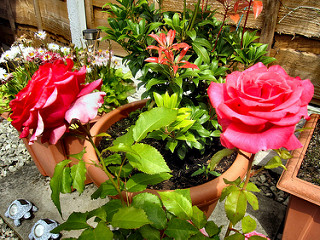

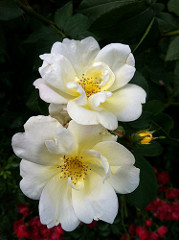

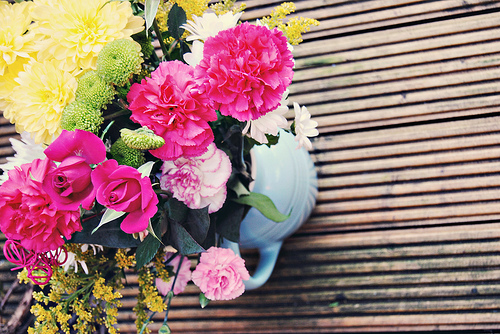

In [6]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Building the dataset

Keras has some convenient methods to read in image data. For instance [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is great for small local datasets. A tutorial on how to use it can be found [here](https://www.tensorflow.org/tutorials/load_data/images), but what if we have so many images, it doesn't fit on a local machine? We can use [tf.data.datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to build a generator based on files in a Google Cloud Storage Bucket.

We have already prepared these images to be stored on the cloud in `gs://cloud-ml-data/img/flower_photos/`. The images are randomly split into a training set with 90% data and an iterable with 10% data listed in CSV files:

Training set: [train_set.csv](https://storage.cloud.google.com/cloud-ml-data/img/flower_photos/train_set.csv)  
Evaluation set: [eval_set.csv](https://storage.cloud.google.com/cloud-ml-data/img/flower_photos/eval_set.csv)  

Explore the format and contents of the train.csv by running:

In [7]:
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv \
    | head -5 > /tmp/input.csv
!cat /tmp/input.csv

gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy


In [8]:
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv | \
    sed 's/,/ /g' | awk '{print $2}' | sort | uniq > /tmp/labels.txt
!cat /tmp/labels.txt

daisy
dandelion
roses
sunflowers
tulips


Let's figure out how to read one of these images from the cloud. TensorFlow's [tf.io.read_file](https://www.tensorflow.org/api_docs/python/tf/io/read_file) can help us read the file contents, but the result will be a [Base64 image string](https://en.wikipedia.org/wiki/Base64). Hmm... not very readable for humans or Tensorflow.

Thankfully, TensorFlow's [tf.image.decode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg) function can decode this string into an integer array, and [tf.image.convert_image_dtype](https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype) can cast it into a 0 - 1 range float. Finally, we'll use [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) to force image dimensions to be consistent for our neural network.

We'll wrap these into a function as we'll be calling these repeatedly. While we're at it, let's also define our constants for our neural network.

In [9]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 32
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [10]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

Is it working? Let's see!

**TODO 1.a:** Run the `decode_img` function and plot it to see a happy looking daisy.

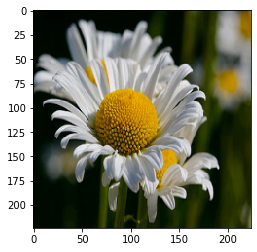

In [12]:
img = tf.io.read_file(
    "gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

# Uncomment to see the image string.
#print(img)
img = decode_img(img, [IMG_WIDTH, IMG_HEIGHT])
plt.imshow((img.numpy()));

One flower down, 3669 more of them to go. Rather than load all the photos in directly, we'll use the file paths given to us in the csv and load the images when we batch. [tf.io.decode_csv](https://www.tensorflow.org/api_docs/python/tf/io/decode_csv) reads in csv rows (or each line in a csv file), while [tf.math.equal](https://www.tensorflow.org/api_docs/python/tf/math/equal) will help us format our label such that it's a boolean array with a truth value corresponding to the class in `CLASS_NAMES`, much like the labels for the MNIST Lab.

In [13]:
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

Next, we'll transform the images to give our network more variety to train on. There are a number of [image manipulation functions](https://www.tensorflow.org/api_docs/python/tf/image). We'll cover just a few:

* [tf.image.random_crop](https://www.tensorflow.org/api_docs/python/tf/image/random_crop) - Randomly deletes the top/bottom rows and left/right columns down to the dimensions specified.
* [tf.image.random_flip_left_right](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right) - Randomly flips the image horizontally
* [tf.image.random_brightness](https://www.tensorflow.org/api_docs/python/tf/image/random_brightness) - Randomly adjusts how dark or light the image is.
* [tf.image.random_contrast](https://www.tensorflow.org/api_docs/python/tf/image/random_contrast) - Randomly adjusts image contrast.

**TODO 1.b:** Add the missing parameters from the random augment functions.

In [14]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8


def read_and_preprocess(image_bytes, label, random_augment=False):
    if random_augment:
        img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
        img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, MAX_DELTA)
        img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
    else:
        img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

Finally, we'll make a function to craft our full dataset using [tf.data.dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). The [tf.data.TextLineDataset](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset) will read in each line in our train/eval csv files to our `decode_csv` function.

[.cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) is key here. It will store the dataset in memory

In [15]:
def load_dataset(csv_of_filenames, batch_size, training=True):
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv).cache()

    if training:
        dataset = dataset \
            .map(read_and_preprocess_with_augment) \
            .shuffle(SHUFFLE_BUFFER) \
            .repeat(count=None)  # Indefinately.
    else:
        dataset = dataset \
            .map(read_and_preprocess) \
            .repeat(count=1)  # Each photo used once.

    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)

We'll test it out with our training set. A batch size of one will allow us to easily look at each augmented image.

In [16]:
train_path = "gs://cloud-ml-data/img/flower_photos/train_set.csv"
train_data = load_dataset(train_path, 1)
itr = iter(train_data)

Run the below cell repeatedly to see the results of different batches. The images have been un-normalized for human eyes. Can you tell what type of flowers they are? Is it fair for the AI to learn on?

In [ ]:
image_batch, label_batch = next(itr)
img = image_batch[0]
plt.imshow(img)
print(label_batch[0])

**Note:** It may take a 4-5 minutes to see result of different batches. 


Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.